# Machball: a very simple tutorial

This is a simple tutorial on how to use and how to make the most of Machball. It assumes that you have a Python distribution with the jupyter environment, numpy (which is one of Machball's dependencies), matplotlib, and Machball installed.

Let's start by importing matplotlib and numpy:

In [1]:
import matplotlib.pyplot as pt
import numpy as np

These packages will allow us to work with arrays and matrices as well as to plot the results:

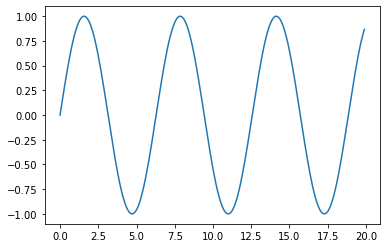

In [2]:
x = np.arange(0,20,0.1)
y = np.sin(x)
pt.plot(x,y)

## Defining an ALD process in Machball

Machball defines an ideal ALD process using the ```ALDIdeal``` class. It implements a first order irreversible Langmuir kinetics. Key parameters are the precursor pressure (in Pa), molecular mass (in amu or grams/mole), the bare or initial sticking probability (the reactivity of a precursor molecule towards an available surface site), the temperature of the process (in K) and the average area of a surface site (in square meters).

### Defining process parameters

We can start by defining some of these parameters:

In [3]:
p = 10
M = 150
beta = 1e-2
T = 473

The average area of a surface site is perhaps the less intuitive of the parameters. However, Machball provides two functions that can be used to calculate this value from the growth per cycle or the mass per cycle.

In [4]:
from machball.utils import sitearea, sitearea_fromqcm

If we look at the documentation of these two functions:

In [5]:
help(sitearea)

Help on function sitearea in module machball.utils:

sitearea(M, density, gpc, nmol=1)
    Average area of a surface site
    
    Calculate the average area of a surface site
    
    Parameters
    ----------
    
    M : float
        Molecular mass in atomic mass units
    density : float
        Density of the film, in g/cm3
    gpc : float
        Growth per cycle, in Angstroms
    nmol : int, optional (default 1)
        Number of precursor molecules per unit formula of the solid
    
    Returns
    -------
    float
        Average area of a surface site in sq. meters



In [6]:
help(sitearea_fromqcm)

Help on function sitearea_fromqcm in module machball.utils:

sitearea_fromqcm(M, mpc, nmol=1)
    Average area of a surface site
    
    Calculate the average area of a surface site from qcm data
    
    Parameters
    ----------
    
    M : float
        Molecular mass in atomic mass units
    mpc : float
        Mass per cycle in  ng/cm2
    nmol : int, optional (default 1)
        Number of precursor molecules per unit formula of the solid
    
    Returns
    -------
    float
        Average area of a surface site in sq. meters



They help establish a connection between experimental observables and the average area of a surface site. Let's use 35 ng/cm2 as the mass gain per cycle and the molar mass of Al2O3:

In [7]:
sitearea_fromqcm(102, 35, 2)

2.4196991981781087e-19

Let's plot the value of the site area for alumina for a range of mass gain per cycle:

Text(0, 0.5, 'Surface site area, nm$^2$')

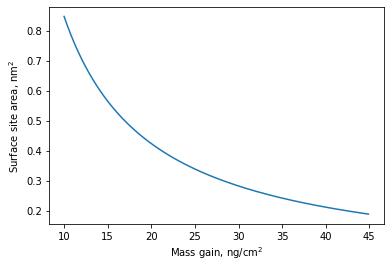

In [8]:
mgain = np.arange(10,45,0.1)
areas = 1e18*sitearea_fromqcm(102, mgain, 2) # Convert to square Angstrom
pt.plot(mgain, areas)
pt.xlabel(r"Mass gain, ng/cm$^2$")
pt.ylabel(r"Surface site area, nm$^2$")

So let's define a value of s0:

In [9]:
s0 = 20e-20

### Working widh ALDIdeal

Let's import ```ALDIdeal``` and define our ALD chemistry:

In [10]:
from machball import ALDIdeal

ald = ALDIdeal(beta, M, T, p, s0, betarec=0)

The first thing we can do is to use the ```dose``` method to calculate the effect of a dose:

In [11]:
ald.dose(0.02) # dose time in seconds

0.9809029825287979

The returned value is the fractional coverage after the dose. It is important to remember that, at this point, doses are not accumulative yet. If you repeat the same dose, you will obtain the same value:

In [12]:
ald.dose(0.02)

0.9809029825287979

This is something that will be changed in the next version, to be able to monitor the effect of multiple microdoses

```ALDIdeal``` also has a method for directly calculating the saturation curve:


In [13]:
times, cov = ald.saturation()

This method returns a list of times and saturation coverages. Let's plot them:

Text(0, 0.5, 'Fractional surface coverage')

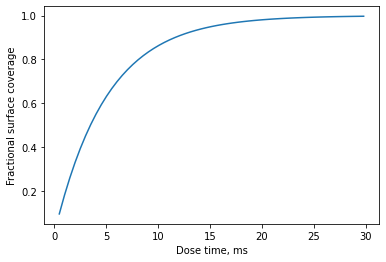

In [14]:
pt.plot(1e3*times,cov)
pt.xlabel("Dose time, ms")
pt.ylabel("Fractional surface coverage")

We can save the saturation profile to a file using ```save_saturation```

In [15]:
from machball.utils import save_saturation
save_saturation("mysaturation.dat", times, cov)

The default is to save it as a space-delimited file. If instead, you want to save it as a comma separated value, we need to specify the ```csv``` flag:

In [16]:
save_saturation("mysaturation.csv", times, cov, csv=True)

In both cases the output can be imported pretty much anywhere. ```mysaturation.csv``` can be directly read by any spreadsheet software, should you use such unholy creatures.

## Simulating ballistic transport inside nanostructures

The first step is to define a nanostructure. For this tutorial, we are going to focus on circular vias, which are pre-defined in Machball. However, Machball allows for the simulation of ballistic transport in arbitrary geometries as long as the view factors are provided.

We first need to import and create our nanostructure:

In [17]:
from machball.ballistic import Via

```Via``` discretizes a circular via in a number of equally sized segments plus the bottom. In order to instantiate a specific via, we need to pass the aspect ratio, defined as the depth/diameter ratio, and the number of vertical segments:

In [18]:
st = Via(100, 200)

We can now use the same interface as we used for exploring the evolution of surface coverage on a flat surface. First, we can look at the result of a specific dose:

In [19]:
cov = ald.dose(0.5, st)

The difference with the flat case is that we are passing the nanostructura as an argument to the ```dose``` method of our ```ALDIdeal``` object that we created before.

If we directly plot the output we see the coverage for all the different elements:

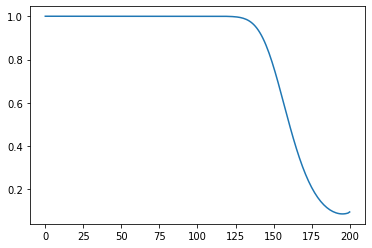

In [20]:
pt.plot(cov)

It is important to note, though, that in the output of ```dose``` also contains the coverage in the bottom of the feature. In fact, if we look at the length of ```cov```:

In [21]:
len(cov)

201

It has 201 elements whereas in the definition of our via we specified 200 vertical segments. The coverage at the bottom is stored in the last element of the array. Therefore, if we want to plot as a function of depth, we need to leave that element out. However, the via object has a method ```region``` that can be used to extract the sidewall data: 

In [22]:
cov_wall = cov[st.region("wall")] # This creates a slice of the array which leaves the last element out

In [23]:
len(cov_wall)

200

Moreover, since we have an aspect ratio of 100 and 200 points in the sidewall, we can define our x axis to represent depth:

In [33]:
x = np.arange(0.25,100,0.5)

Text(0, 0.5, 'Surface coverage')

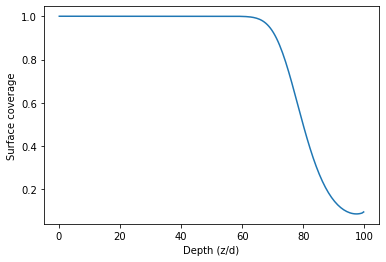

In [34]:
pt.plot(x, cov_wall)
pt.xlabel("Depth (z/d)")
pt.ylabel("Surface coverage")

Like in the flat case, we can also directly calculate the saturation profile. This will give us a sequence of coverage profiles as a function of time:

In [25]:
times2, covs2 = ald.saturation(st, endcov=0.95, verbose=False)

```covs2``` is a 2D array. If we look at its shape:

In [26]:
covs2.shape

(97, 201)

We see that each row represents a coverage profile for a given time.  

Using slices we can plot specific times:

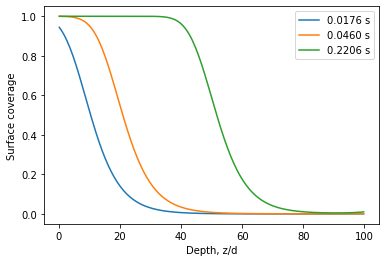

In [37]:
pt.plot(x, covs2[10,st.region("wall")], label=("%6.4f s" % times2[10]))
pt.plot(x, covs2[20,st.region("wall")], label=("%6.4f s" % times2[20]))
pt.plot(x, covs2[50,st.region("wall")], label=("%6.4f s" % times2[50]))
pt.xlabel("Depth, z/d")
pt.ylabel("Surface coverage")
pt.legend()

Note that, as before, we have used ```region``` to keep just the sidewall regions of our via. We can also view the 2D array as an image:

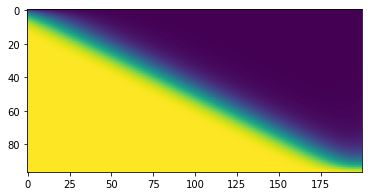

In [38]:
pt.imshow(covs2[:,st.region("wall")])

However, it is important to note that the times are not linearly spaced, since Machball uses an adaptive timestep to evolve the fractional coverage with time:

In [29]:
times2

array([0.00116806, 0.0023257 , 0.00375969, 0.00518084, 0.00659071,
       0.00826952, 0.00993597, 0.01159172, 0.01351175, 0.01542096,
       0.01759161, 0.01975197, 0.02217196, 0.02458257, 0.02725171,
       0.02991249, 0.03283113, 0.0360067 , 0.03917478, 0.04259959,
       0.04601785, 0.04969265, 0.05362351, 0.05754852, 0.06172949,
       0.06590523, 0.07033684, 0.07502397, 0.07970633, 0.08464415,
       0.08957763, 0.09476648, 0.09995134, 0.10539149, 0.11108671,
       0.1167782 , 0.1227247 , 0.12866773, 0.1348657 , 0.14131846,
       0.14776794, 0.15447215, 0.16117329, 0.16812911, 0.17508203,
       0.18228958, 0.18975165, 0.19721095, 0.20492472, 0.21263587,
       0.22060146, 0.22882137, 0.23703878, 0.24551048, 0.25397979,
       0.26270337, 0.27142466, 0.28040019, 0.28962988, 0.29885736,
       0.30833898, 0.31781848, 0.32755208, 0.33728365, 0.3472693 ,
       0.35750897, 0.36774667, 0.37823836, 0.38872815, 0.39947192,
       0.41046959, 0.42146543, 0.43271516, 0.44396312, 0.45546

We can also plot the average surface coverage as a function of time

Text(0, 0.5, 'Average surface coverage')

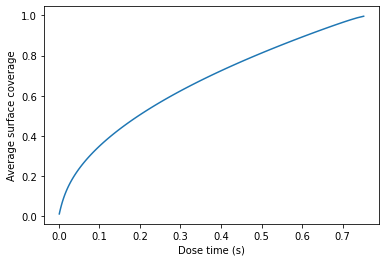

In [30]:
pt.plot(times2, np.mean(covs2,axis=1))
pt.xlabel("Dose time (s)")
pt.ylabel("Average surface coverage")

The resulting profiles has the parabolic shape that is expected from a transport-limited process.

Finally, we can export the coverage profiles and the times to a file:

In [31]:
from machball.utils import save_saturationprofile

In [32]:
save_saturationprofile("via100.dat", times2, covs2)

## Next steps

This tutorial just went over some of the more basic features of Machball. There are other capabilities we didn't go through that are fully documented, though not easily accessible. These include the ability to work with other types of eatures, to compare with constant reaction probability processes, and to expand the range of processes to incoporate surface recombination and soft-saturating reactions.